<a href="https://colab.research.google.com/github/fugugdeveloper/Brain-Tumor-Segmentation-with-U-net/blob/master/brain_tumer_segmentation_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%cd "/content/drive/MyDrive/Colab Notebooks/Segmentation"

#%cd "/content/drive/MyDrive/Colab Notebooks/Segmentation"

/content/drive/MyDrive/Colab Notebooks/Segmentation


**Drive Mounting**

In [ ]:
#from google.colab import drive

#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -q "/content/drive/MyDrive/Colab Notebooks/Segmentation/segmentation_dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/Segmentation/"


In [ ]:
# Setting Size Parameters of images
img_width = 224
img_height = 224
IMAGE_SIZE = 224
BATCH_SIZE = 16
SEED = 42

## Loading Image and Mask Paths

In [ ]:
image_filenames_train = []

# Creating a list of all the images containing the word mask
mask_files = glob('/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace("_mask", ""))

print("Image Filenames:",image_filenames_train[:10])
print("Mask Files: ", mask_files)
len(image_filenames_train)

Image Filenames: ['/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif', '/content/drive/MyDrive/Colab Notebooks/Segmentation/k

3929

## Plotting few images and masks

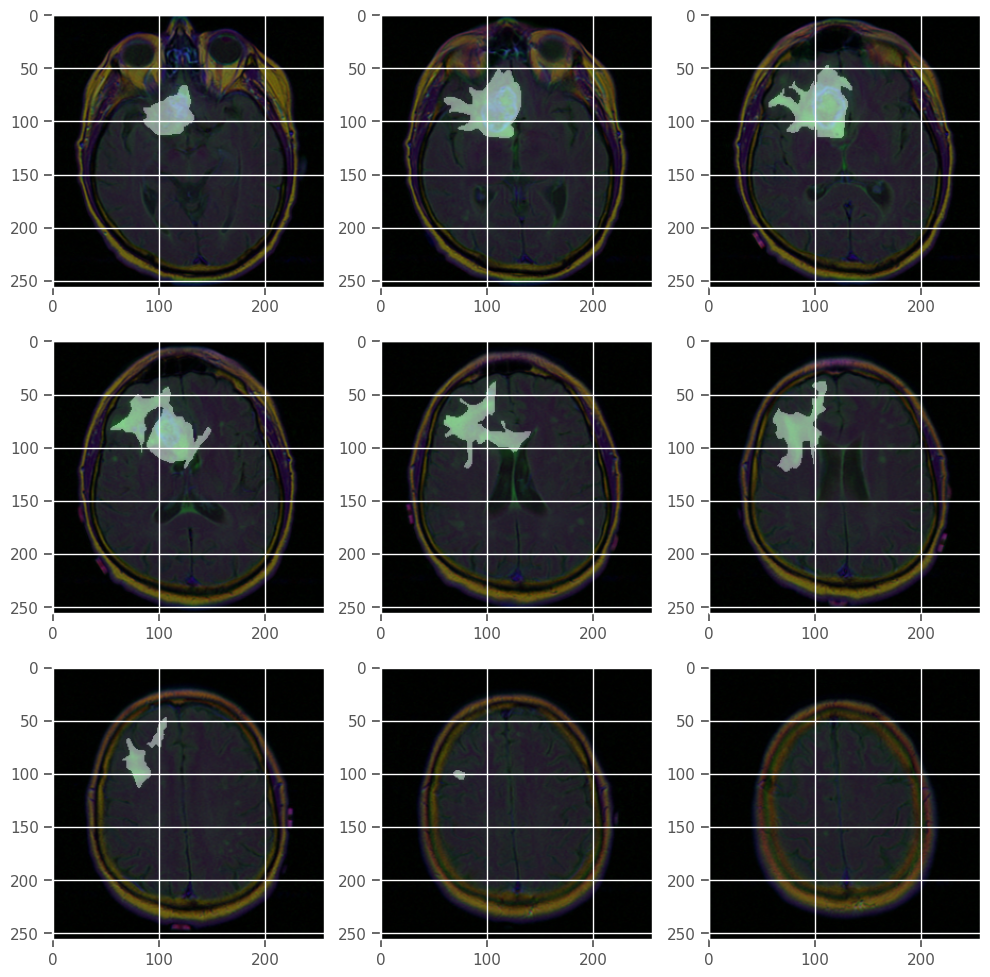

In [ ]:
plot_from_img_path(3,3, image_filenames_train, mask_files)

## Create Dataframe and split data on train set, validation set and test set

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, "mask" : mask_files})

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1) # Test Size - 0.1 means 10%

# Further split this into val and test
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


## **Data generator, data augmentation and adjust data**

In [ ]:
# Referring from https://github.com/zhixuhao/unet/blob/master/data.py

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 1e-6

**Unet Model Architecture**

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, padding="same")(inputs)
    conv1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, 3, padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D(2)(conv1)

    conv2 = Conv2D(128, 3, padding="same")(pool1)
    conv2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, 3, padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D(2)(conv2)

    conv3 = Conv2D(256, 3, padding="same")(pool2)
    conv3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, 3, padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    pool3 = MaxPooling2D(2)(conv3)

    conv4 = Conv2D(512, 3, padding="same")(pool3)
    conv4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, 3, padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    pool4 = MaxPooling2D(2)(conv4)

    conv5 = Conv2D(1024, 3, padding="same")(pool4)
    conv5 = Activation("relu")(conv5)
    conv5 = Conv2D(1024, 3, padding="same")(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    up6 = concatenate([
        Conv2DTranspose(512, 2, strides=2, padding="same")(conv5), conv4
    ])
    conv6 = Conv2D(512, 3, padding="same")(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, 3, padding="same")(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = concatenate([
        Conv2DTranspose(256, 2, strides=2, padding="same")(conv6), conv3
    ])
    conv7 = Conv2D(256, 3, padding="same")(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, 3, padding="same")(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)

    up8 = concatenate([
        Conv2DTranspose(128, 2, strides=2, padding="same")(conv7), conv2
    ])
    conv8 = Conv2D(128, 3, padding="same")(up8)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, 3, padding="same")(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation("relu")(conv8)

    up9 = concatenate([
        Conv2DTranspose(64, 2, strides=2, padding="same")(conv8), conv1
    ])
    conv9 = Conv2D(64, 3, padding="same")(up9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, 3, padding="same")(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)

    outputs = Conv2D(1, 1, activation="sigmoid")(conv9)

    return Model(inputs=inputs, outputs=outputs)


**Utility**

In [ ]:

# Styling
plt.style.use("ggplot")
sns.set_theme(style="ticks")

# ----------------------------
# Visualization Function
# ----------------------------
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        plt.imshow(image)
        plt.imshow(mask, cmap='Reds', alpha=0.4)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Dice Coefficient Metric
# ----------------------------
def dice_coefficients(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficients(y_true, y_pred, smooth)

# ----------------------------
# IOU Metric
# ----------------------------
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# ----------------------------
# Jaccard Distance Loss
# ----------------------------
def jaccard_distance(y_true, y_pred, smooth=1e-6):
    return 1 - iou(y_true, y_pred, smooth)


In [ ]:

# Data augmentation
train_generator_param = dict(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create generators (assuming you have a custom train_generator function)
train_gen = train_generator(df_train, BATCH_SIZE, train_generator_param, target_size=(img_height, img_width))
test_gen = train_generator(df_val, BATCH_SIZE, {}, target_size=(img_height, img_width))

# Model, optimizer, compile
model = unet(input_size=(img_height, img_width, 3))
opt = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=opt,
    loss=dice_coefficient_loss,
    metrics=["binary_accuracy", iou, dice_coefficients]
)

# Callbacks
callbacks = [
    ModelCheckpoint('unet.h5', verbose=1, save_best_only=True)
]

# Training
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - binary_accuracy: 0.7415 - dice_coefficients: 0.0536 - iou: 0.0278 - loss: 0.9464Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.97954, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 821ms/step - binary_accuracy: 0.7430 - dice_coefficients: 0.0539 - iou: 0.0280 - loss: 0.9461 - val_binary_accuracy: 0.9905 - val_dice_coefficients: 0.0205 - val_iou: 0.0103 - val_loss: 0.9795
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - binary_accuracy: 0.9750 - dice_coefficients: 0.1140 - iou: 0.0611 - loss: 0.8832
Epoch 2: val_loss did not improve from 0.97954
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 757ms/step - binary_accuracy: 0.9750 - dice_coefficients: 0.1141 - iou: 0.0612 - loss: 0.8830 - val_binary_accuracy: 0.9904 - val_dice_coefficients: 0.0188 - val_iou: 0.0095 - val_loss: 0.9812
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - binary_accuracy: 0.9796 - dice_coefficients: 0.1425 - iou: 0.0776 - loss: 0.8566
Epoch 3: val_loss did not improve from 0.97954
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 738ms/step - binary_accuracy: 0.9797 - dice_coefficients: 0.1427 - iou: 0.0777 - loss: 0.8565 - val_binary_accuracy: 0.9622 - val_dice_coefficients: 0.0122 -

88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 776ms/step - binary_accuracy: 0.9825 - dice_coefficients: 0.1625 - iou: 0.0900 - loss: 0.8342 - val_binary_accuracy: 0.9341 - val_dice_coefficients: 0.0551 - val_iou: 0.0287 - val_loss: 0.9496
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - binary_accuracy: 0.9881 - dice_coefficients: 0.2139 - iou: 0.1218 - loss: 0.7883
Epoch 5: val_loss improved from 0.94960 to 0.93364, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 833ms/step - binary_accuracy: 0.9881 - dice_coefficients: 0.2141 - iou: 0.1219 - loss: 0.7881 - val_binary_accuracy: 0.8853 - val_dice_coefficients: 0.0664 - val_iou: 0.0345 - val_loss: 0.9336
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - binary_accuracy: 0.9874 - dice_coefficients: 0.2437 - iou: 0.1418 - loss: 0.7539
Epoch 6: val_loss improved from 0.93364 to 0.83440, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 844ms/step - binary_accuracy: 0.9874 - dice_coefficients: 0.2441 - iou: 0.1421 - loss: 0.7536 - val_binary_accuracy: 0.9593 - val_dice_coefficients: 0.1708 - val_iou: 0.0942 - val_loss: 0.8344
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - binary_accuracy: 0.9887 - dice_coefficients: 0.2828 - iou: 0.1703 - loss: 0.7151
Epoch 7: val_loss improved from 0.83440 to 0.63988, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 833ms/step - binary_accuracy: 0.9887 - dice_coefficients: 0.2834 - iou: 0.1707 - loss: 0.7145 - val_binary_accuracy: 0.9936 - val_dice_coefficients: 0.3458 - val_iou: 0.2143 - val_loss: 0.6399
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - binary_accuracy: 0.9889 - dice_coefficients: 0.3300 - iou: 0.2066 - loss: 0.6692
Epoch 8: val_loss improved from 0.63988 to 0.59484, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 834ms/step - binary_accuracy: 0.9889 - dice_coefficients: 0.3307 - iou: 0.2071 - loss: 0.6685 - val_binary_accuracy: 0.9951 - val_dice_coefficients: 0.4047 - val_iou: 0.2574 - val_loss: 0.5948
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - binary_accuracy: 0.9919 - dice_coefficients: 0.3973 - iou: 0.2579 - loss: 0.5971
Epoch 9: val_loss did not improve from 0.59484
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 803ms/step - binary_accuracy: 0.9919 - dice_coefficients: 0.3980 - iou: 0.2584 - loss: 0.5965 - val_binary_accuracy: 0.9955 - val_dice_coefficients: 0.3803 - val_iou: 0.2401 - val_loss: 0.6039
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - binary_accuracy: 0.9915 - dice_coefficients: 0.4477 - iou: 0.3020 - loss: 0.5549
Epoch 10: val_loss improved from 0.59484 to 0.55074, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 726ms/step - binary_accuracy: 0.9915 - dice_coefficients: 0.4485 - iou: 0.3026 - loss: 0.5541 - val_binary_accuracy: 0.9948 - val_dice_coefficients: 0.4393 - val_iou: 0.2871 - val_loss: 0.5507
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - binary_accuracy: 0.9925 - dice_coefficients: 0.4828 - iou: 0.3380 - loss: 0.5198
Epoch 11: val_loss improved from 0.55074 to 0.54301, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 755ms/step - binary_accuracy: 0.9925 - dice_coefficients: 0.4837 - iou: 0.3387 - loss: 0.5189 - val_binary_accuracy: 0.9868 - val_dice_coefficients: 0.4408 - val_iou: 0.2911 - val_loss: 0.5430
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - binary_accuracy: 0.9923 - dice_coefficients: 0.5112 - iou: 0.3663 - loss: 0.4900
Epoch 12: val_loss improved from 0.54301 to 0.37859, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 840ms/step - binary_accuracy: 0.9923 - dice_coefficients: 0.5123 - iou: 0.3672 - loss: 0.4889 - val_binary_accuracy: 0.9958 - val_dice_coefficients: 0.6289 - val_iou: 0.4637 - val_loss: 0.3786
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - binary_accuracy: 0.9925 - dice_coefficients: 0.5234 - iou: 0.3800 - loss: 0.4788
Epoch 13: val_loss improved from 0.37859 to 0.36608, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 832ms/step - binary_accuracy: 0.9925 - dice_coefficients: 0.5246 - iou: 0.3810 - loss: 0.4777 - val_binary_accuracy: 0.9968 - val_dice_coefficients: 0.6418 - val_iou: 0.4783 - val_loss: 0.3661
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - binary_accuracy: 0.9933 - dice_coefficients: 0.5993 - iou: 0.4578 - loss: 0.4030
Epoch 14: val_loss improved from 0.36608 to 0.32955, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 838ms/step - binary_accuracy: 0.9933 - dice_coefficients: 0.6003 - iou: 0.4588 - loss: 0.4019 - val_binary_accuracy: 0.9971 - val_dice_coefficients: 0.6674 - val_iou: 0.5042 - val_loss: 0.3295
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - binary_accuracy: 0.9931 - dice_coefficients: 0.6140 - iou: 0.4701 - loss: 0.3878
Epoch 15: val_loss did not improve from 0.32955
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 798ms/step - binary_accuracy: 0.9931 - dice_coefficients: 0.6149 - iou: 0.4710 - loss: 0.3869 - val_binary_accuracy: 0.9961 - val_dice_coefficients: 0.6534 - val_iou: 0.4900 - val_loss: 0.3465
Epoch 16/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - binary_accuracy: 0.9945 - dice_coefficients: 0.6210 - iou: 0.4824 - loss: 0.3720
Epoch 16: val_loss improved from 0.32955 to 0.28236, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 797ms/step - binary_accuracy: 0.9945 - dice_coefficients: 0.6221 - iou: 0.4834 - loss: 0.3710 - val_binary_accuracy: 0.9965 - val_dice_coefficients: 0.7217 - val_iou: 0.5714 - val_loss: 0.2824
Epoch 17/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - binary_accuracy: 0.9950 - dice_coefficients: 0.6507 - iou: 0.5111 - loss: 0.3499
Epoch 17: val_loss improved from 0.28236 to 0.23286, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 837ms/step - binary_accuracy: 0.9951 - dice_coefficients: 0.6516 - iou: 0.5120 - loss: 0.3490 - val_binary_accuracy: 0.9972 - val_dice_coefficients: 0.7703 - val_iou: 0.6298 - val_loss: 0.2329
Epoch 18/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - binary_accuracy: 0.9935 - dice_coefficients: 0.6324 - iou: 0.5040 - loss: 0.3682
Epoch 18: val_loss did not improve from 0.23286
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 795ms/step - binary_accuracy: 0.9936 - dice_coefficients: 0.6335 - iou: 0.5051 - loss: 0.3670 - val_binary_accuracy: 0.9961 - val_dice_coefficients: 0.6984 - val_iou: 0.5480 - val_loss: 0.3090
Epoch 19/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - binary_accuracy: 0.9943 - dice_coefficients: 0.6698 - iou: 0.5441 - loss: 0.3318
Epoch 19: val_loss improved from 0.23286 to 0.22891, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 753ms/step - binary_accuracy: 0.9943 - dice_coefficients: 0.6710 - iou: 0.5453 - loss: 0.3307 - val_binary_accuracy: 0.9970 - val_dice_coefficients: 0.7404 - val_iou: 0.6070 - val_loss: 0.2289
Epoch 20/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.6817 - iou: 0.5497 - loss: 0.3195
Epoch 20: val_loss improved from 0.22891 to 0.21879, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 847ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.6827 - iou: 0.5508 - loss: 0.3185 - val_binary_accuracy: 0.9970 - val_dice_coefficients: 0.7501 - val_iou: 0.6230 - val_loss: 0.2188
Epoch 21/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - binary_accuracy: 0.9941 - dice_coefficients: 0.6834 - iou: 0.5586 - loss: 0.3160
Epoch 21: val_loss improved from 0.21879 to 0.21283, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 845ms/step - binary_accuracy: 0.9941 - dice_coefficients: 0.6845 - iou: 0.5597 - loss: 0.3150 - val_binary_accuracy: 0.9973 - val_dice_coefficients: 0.7879 - val_iou: 0.6543 - val_loss: 0.2128
Epoch 22/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - binary_accuracy: 0.9950 - dice_coefficients: 0.7100 - iou: 0.5836 - loss: 0.2903
Epoch 22: val_loss improved from 0.21283 to 0.16952, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - binary_accuracy: 0.9950 - dice_coefficients: 0.7109 - iou: 0.5846 - loss: 0.2893 - val_binary_accuracy: 0.9974 - val_dice_coefficients: 0.7975 - val_iou: 0.6869 - val_loss: 0.1695
Epoch 23/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - binary_accuracy: 0.9953 - dice_coefficients: 0.7263 - iou: 0.6126 - loss: 0.2742
Epoch 23: val_loss did not improve from 0.16952
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 796ms/step - binary_accuracy: 0.9953 - dice_coefficients: 0.7273 - iou: 0.6136 - loss: 0.2731 - val_binary_accuracy: 0.9974 - val_dice_coefficients: 0.8168 - val_iou: 0.6942 - val_loss: 0.1816
Epoch 24/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - binary_accuracy: 0.9938 - dice_coefficients: 0.6921 - iou: 0.5729 - loss: 0.3082
Epoch 24: val_loss did not improve from 0.16952
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 713ms/step - binary_accuracy: 0.9939 - dice_coefficients: 0.6933 - iou: 0.5741 - loss: 0.3070 - val_binary_accuracy: 0.9967 - val_dice_coefficients: 0.77

88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 753ms/step - binary_accuracy: 0.9933 - dice_coefficients: 0.6913 - iou: 0.5701 - loss: 0.3084 - val_binary_accuracy: 0.9974 - val_dice_coefficients: 0.8448 - val_iou: 0.7330 - val_loss: 0.1552
Epoch 27/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - binary_accuracy: 0.9944 - dice_coefficients: 0.6966 - iou: 0.5798 - loss: 0.3034
Epoch 27: val_loss did not improve from 0.15522
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 799ms/step - binary_accuracy: 0.9944 - dice_coefficients: 0.6978 - iou: 0.5811 - loss: 0.3022 - val_binary_accuracy: 0.9974 - val_dice_coefficients: 0.8229 - val_iou: 0.7019 - val_loss: 0.1771
Epoch 28/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.7490 - iou: 0.6432 - loss: 0.2515
Epoch 28: val_loss did not improve from 0.15522
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 719ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.7500 - iou: 0.6444 - loss: 0.2504 - val_binary_accuracy: 0.9972 - val_dice_coefficients: 0.81

88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 754ms/step - binary_accuracy: 0.9942 - dice_coefficients: 0.7076 - iou: 0.5946 - loss: 0.2937 - val_binary_accuracy: 0.9975 - val_dice_coefficients: 0.8576 - val_iou: 0.7526 - val_loss: 0.1441
Epoch 30/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - binary_accuracy: 0.9939 - dice_coefficients: 0.7358 - iou: 0.6328 - loss: 0.2651
Epoch 30: val_loss did not improve from 0.14409
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 793ms/step - binary_accuracy: 0.9939 - dice_coefficients: 0.7370 - iou: 0.6340 - loss: 0.2639 - val_binary_accuracy: 0.9975 - val_dice_coefficients: 0.8178 - val_iou: 0.7169 - val_loss: 0.1483
Epoch 31/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - binary_accuracy: 0.9948 - dice_coefficients: 0.7333 - iou: 0.6270 - loss: 0.2675
Epoch 31: val_loss did not improve from 0.14409
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 710ms/step - binary_accuracy: 0.9948 - dice_coefficients: 0.7344 - iou: 0.6282 - loss: 0.2663 - val_binary_accuracy: 0.9967 - val_dice_coefficients: 0.80

88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 763ms/step - binary_accuracy: 0.9952 - dice_coefficients: 0.7257 - iou: 0.6102 - loss: 0.2751 - val_binary_accuracy: 0.9977 - val_dice_coefficients: 0.8479 - val_iou: 0.7402 - val_loss: 0.1419
Epoch 33/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - binary_accuracy: 0.9939 - dice_coefficients: 0.7067 - iou: 0.6008 - loss: 0.2942
Epoch 33: val_loss improved from 0.14188 to 0.13640, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - binary_accuracy: 0.9939 - dice_coefficients: 0.7079 - iou: 0.6021 - loss: 0.2929 - val_binary_accuracy: 0.9976 - val_dice_coefficients: 0.8662 - val_iou: 0.7663 - val_loss: 0.1364
Epoch 34/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - binary_accuracy: 0.9938 - dice_coefficients: 0.7334 - iou: 0.6307 - loss: 0.2672
Epoch 34: val_loss did not improve from 0.13640
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 803ms/step - binary_accuracy: 0.9939 - dice_coefficients: 0.7346 - iou: 0.6320 - loss: 0.2659 - val_binary_accuracy: 0.9976 - val_dice_coefficients: 0.8656 - val_iou: 0.7650 - val_loss: 0.1374
Epoch 35/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - binary_accuracy: 0.9953 - dice_coefficients: 0.7316 - iou: 0.6354 - loss: 0.2691
Epoch 35: val_loss improved from 0.13640 to 0.13379, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 761ms/step - binary_accuracy: 0.9953 - dice_coefficients: 0.7328 - iou: 0.6366 - loss: 0.2679 - val_binary_accuracy: 0.9976 - val_dice_coefficients: 0.8649 - val_iou: 0.7634 - val_loss: 0.1338
Epoch 36/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - binary_accuracy: 0.9951 - dice_coefficients: 0.7370 - iou: 0.6346 - loss: 0.2636
Epoch 36: val_loss did not improve from 0.13379
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 800ms/step - binary_accuracy: 0.9951 - dice_coefficients: 0.7381 - iou: 0.6358 - loss: 0.2625 - val_binary_accuracy: 0.9977 - val_dice_coefficients: 0.8192 - val_iou: 0.7202 - val_loss: 0.1469
Epoch 37/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - binary_accuracy: 0.9955 - dice_coefficients: 0.7411 - iou: 0.6383 - loss: 0.2597
Epoch 37: val_loss did not improve from 0.13379
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 718ms/step - binary_accuracy: 0.9955 - dice_coefficients: 0.7422 - iou: 0.6396 - loss: 0.2585 - val_binary_accuracy: 0.9977 - val_dice_coefficients: 0.82

88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 753ms/step - binary_accuracy: 0.9942 - dice_coefficients: 0.7322 - iou: 0.6279 - loss: 0.2680 - val_binary_accuracy: 0.9980 - val_dice_coefficients: 0.8375 - val_iou: 0.7479 - val_loss: 0.1278
Epoch 41/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - binary_accuracy: 0.9952 - dice_coefficients: 0.7246 - iou: 0.6215 - loss: 0.2758
Epoch 41: val_loss did not improve from 0.12780
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 795ms/step - binary_accuracy: 0.9952 - dice_coefficients: 0.7259 - iou: 0.6230 - loss: 0.2745 - val_binary_accuracy: 0.9978 - val_dice_coefficients: 0.8647 - val_iou: 0.7646 - val_loss: 0.1372
Epoch 42/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - binary_accuracy: 0.9948 - dice_coefficients: 0.7449 - iou: 0.6503 - loss: 0.2553
Epoch 42: val_loss did not improve from 0.12780
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 719ms/step - binary_accuracy: 0.9948 - dice_coefficients: 0.7461 - iou: 0.6515 - loss: 0.2541 - val_binary_accuracy: 0.9976 - val_dice_coefficients: 0.87

88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 761ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.7219 - iou: 0.6174 - loss: 0.2787 - val_binary_accuracy: 0.9979 - val_dice_coefficients: 0.8554 - val_iou: 0.7631 - val_loss: 0.1217
Epoch 44/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.7466 - iou: 0.6582 - loss: 0.2540
Epoch 44: val_loss improved from 0.12167 to 0.12013, saving model to unet.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 843ms/step - binary_accuracy: 0.9947 - dice_coefficients: 0.7479 - iou: 0.6595 - loss: 0.2527 - val_binary_accuracy: 0.9978 - val_dice_coefficients: 0.8777 - val_iou: 0.7837 - val_loss: 0.1201
Epoch 45/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - binary_accuracy: 0.9949 - dice_coefficients: 0.7541 - iou: 0.6580 - loss: 0.2456
Epoch 45: val_loss did not improve from 0.12013
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 796ms/step - binary_accuracy: 0.9949 - dice_coefficients: 0.7552 - iou: 0.6592 - loss: 0.2445 - val_binary_accuracy: 0.9976 - val_dice_coefficients: 0.8740 - val_iou: 0.7777 - val_loss: 0.1294
Epoch 46/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - binary_accuracy: 0.9945 - dice_coefficients: 0.7272 - iou: 0.6270 - loss: 0.2727
Epoch 46: val_loss did not improve from 0.12013
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 716ms/step - binary_accuracy: 0.9946 - dice_coefficients: 0.7284 - iou: 0.6282 - loss: 0.2715 - val_binary_accuracy: 0.9974 - val_dice_coefficients: 0.83

In [ ]:
import pprint

pprint.pprint(history.history)

{'binary_accuracy': [0.8803555965423584,
                     0.9786312580108643,
                     0.9825943112373352,
                     0.9859619140625,
                     0.9894484877586365,
                     0.9901390075683594,
                     0.9917076230049133,
                     0.9928865432739258,
                     0.9940345287322998,
                     0.9943144917488098,
                     0.9948285222053528,
                     0.9950529336929321,
                     0.9952054023742676,
                     0.9959245324134827,
                     0.9954380989074707,
                     0.9960453510284424,
                     0.9963183403015137,
                     0.9958978891372681,
                     0.9964120984077454,
                     0.9964588284492493,
                     0.9962541460990906,
                     0.9966672658920288,
                     0.9970434308052063,
                     0.9963528513908386,
                   

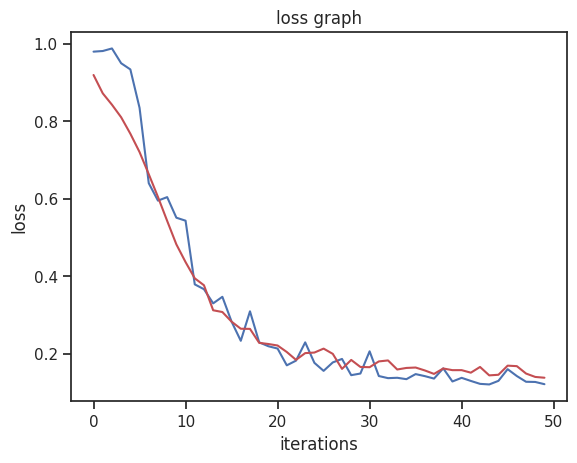

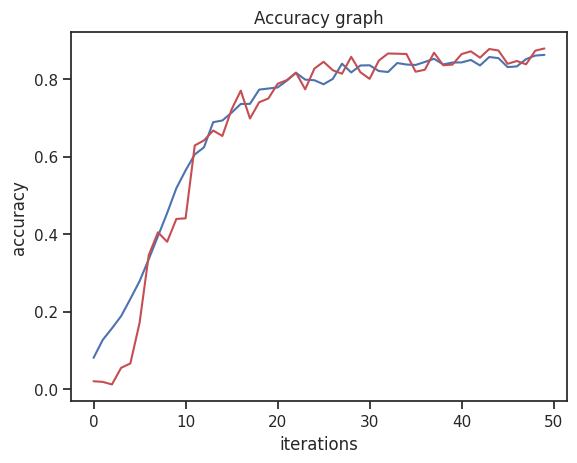

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [ ]:
model = load_model('unet.h5', custom_objects={'dice_coefficient_loss': dice_coefficient_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(img_height, img_width)  )

results = model.evaluate(test_gen, steps=len(df_test) // BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - binary_accuracy: 0.9979 - dice_coefficients: 0.8791 - iou: 0.7849 - loss: 0.1209
Test Loss  0.1258234977722168
Test IoU  0.9976981282234192
Test Dice Coefficient  0.7773352265357971


## Plotting Predicted Masks Segmentation results from the Test Image set

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


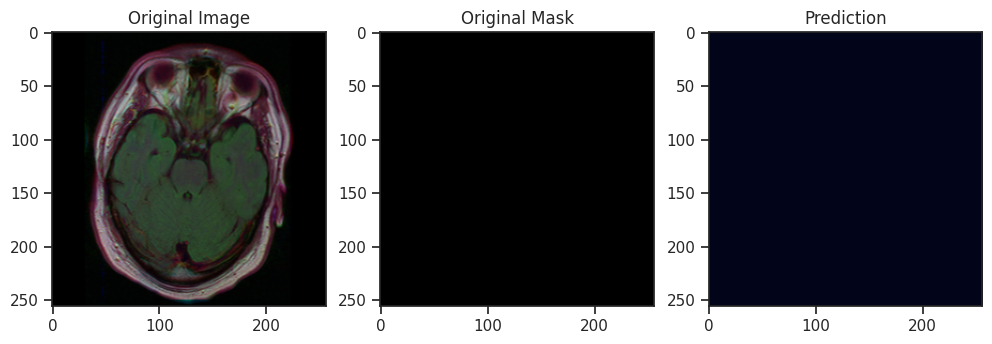

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


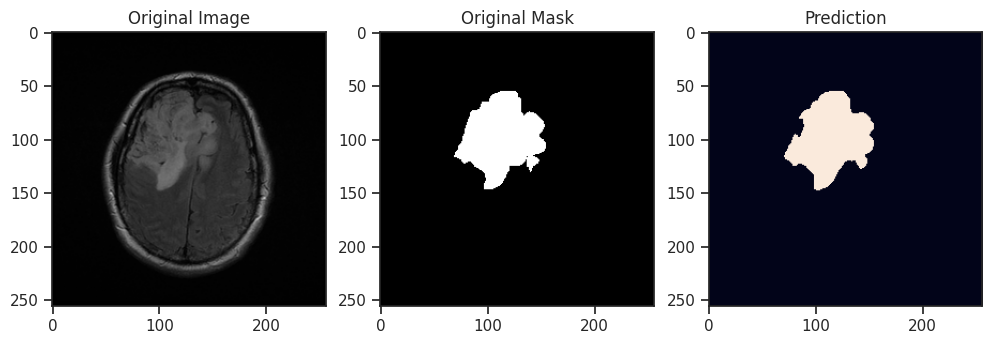

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


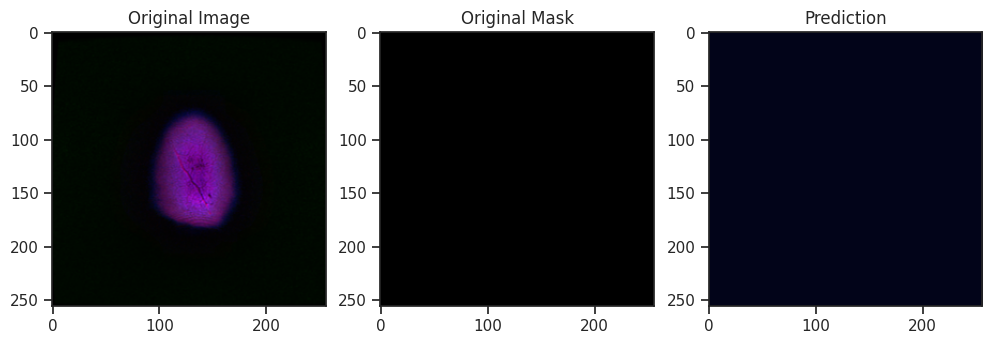

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


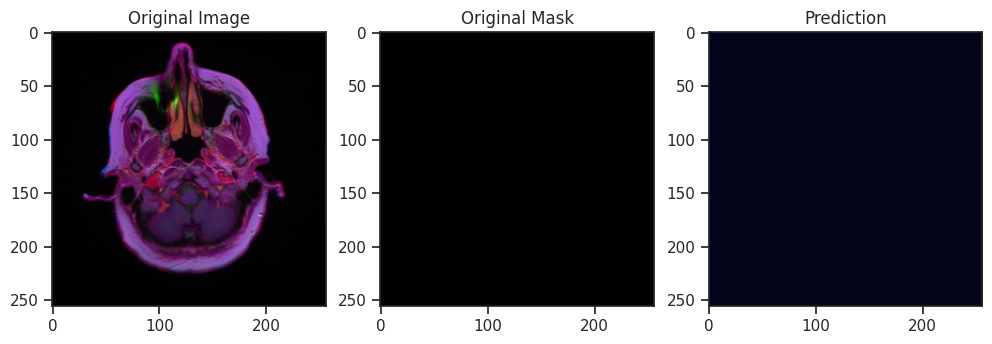

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


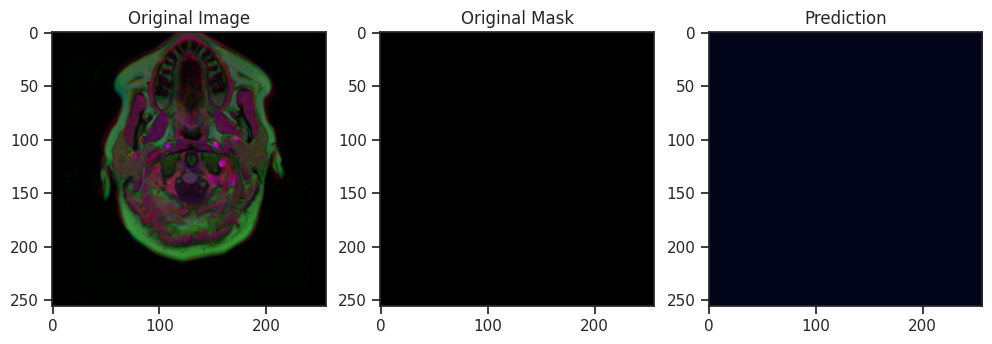

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


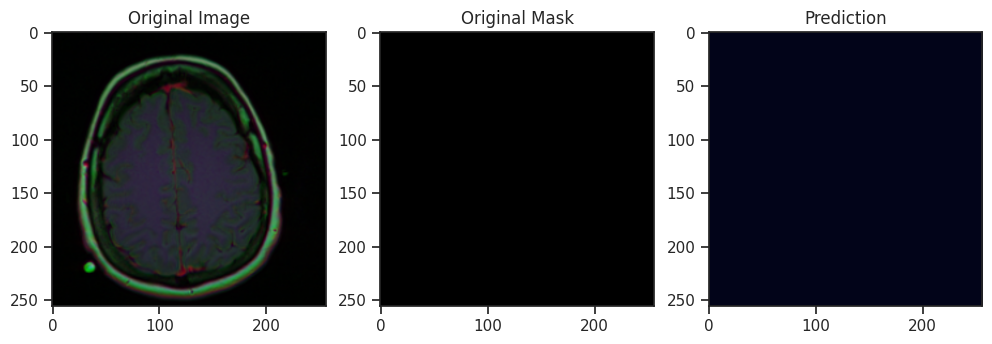

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


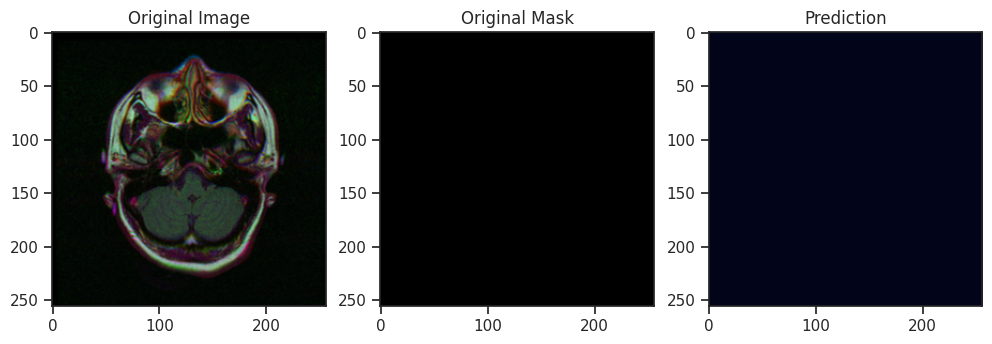

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


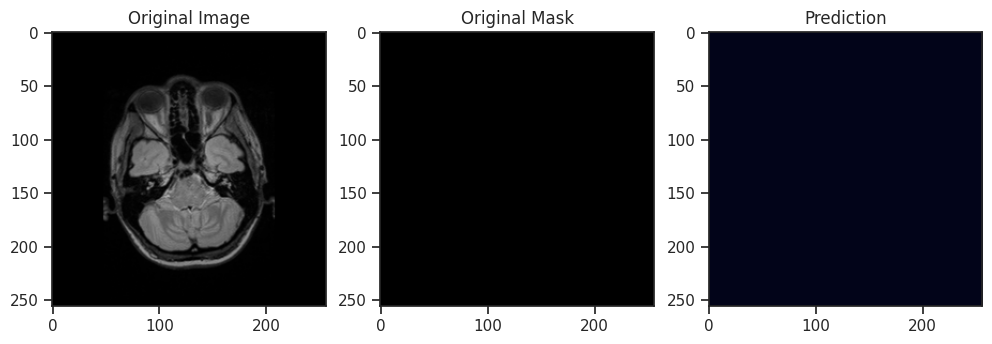

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


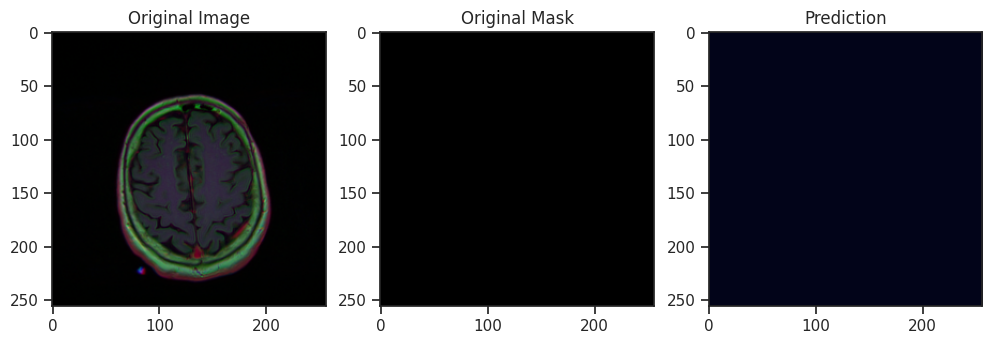

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


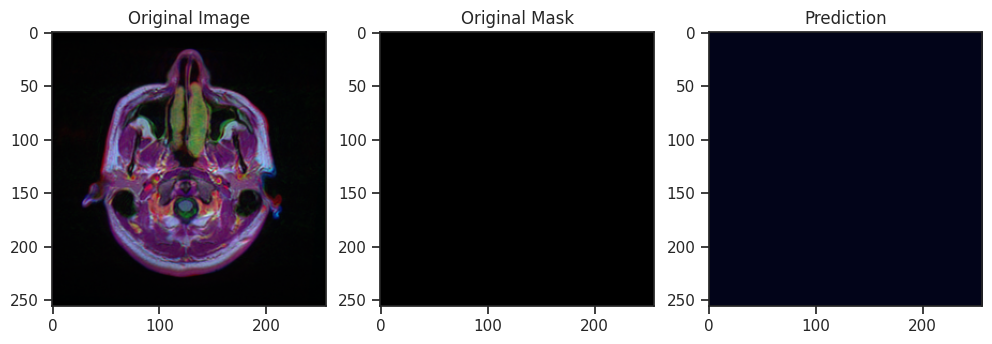

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


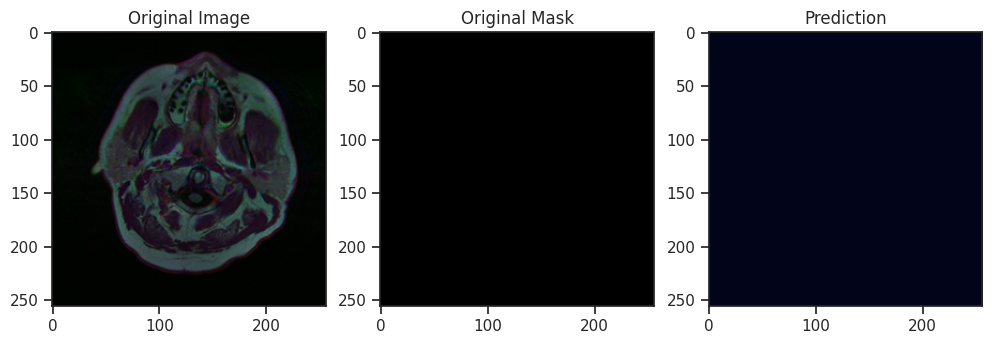

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


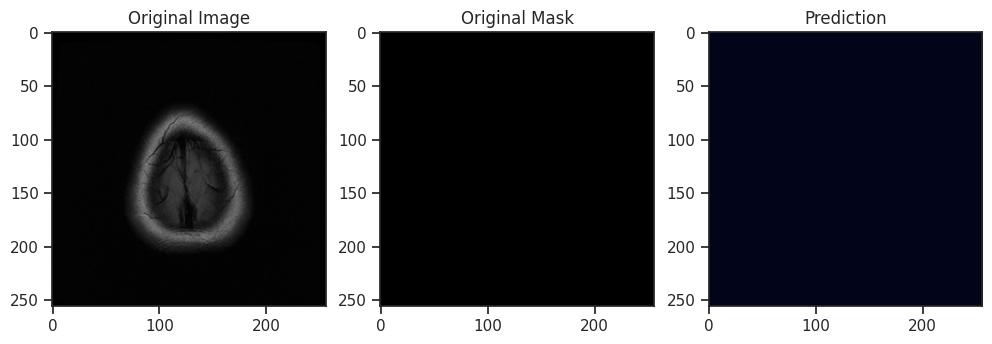

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


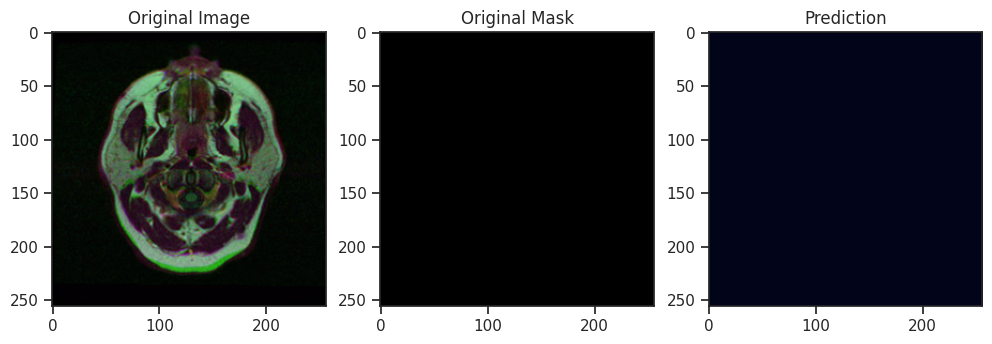

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


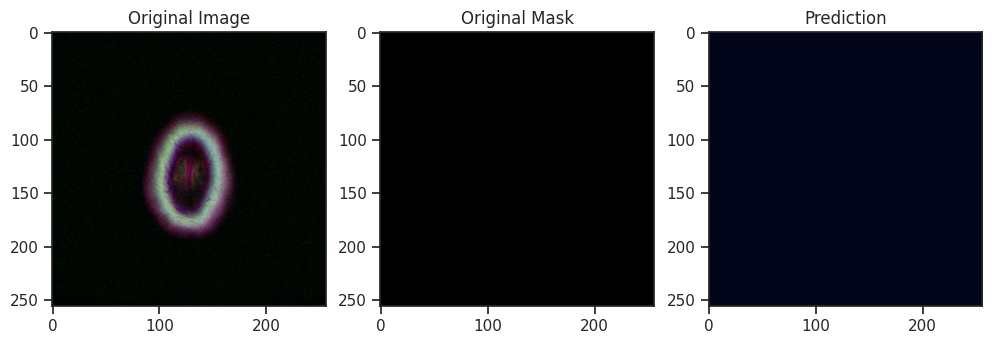

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


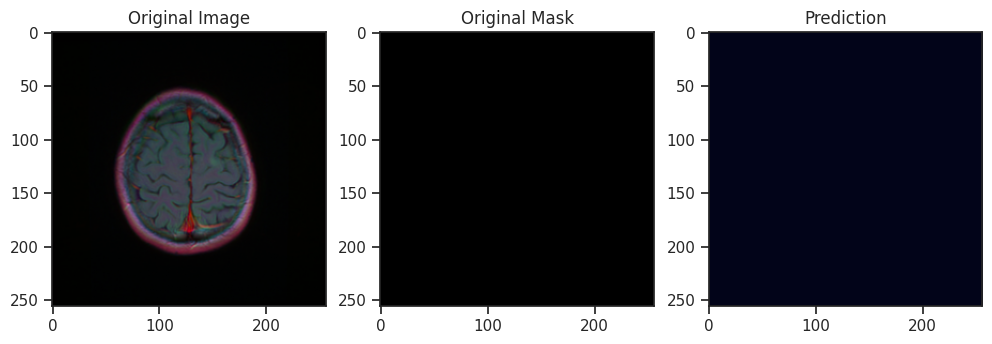

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


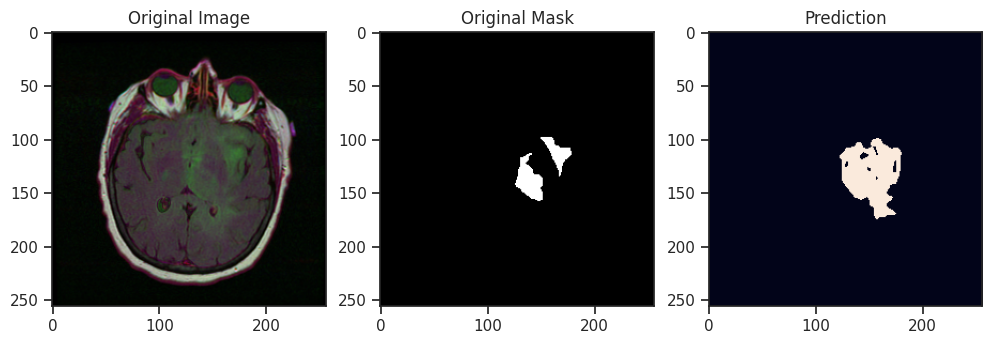

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


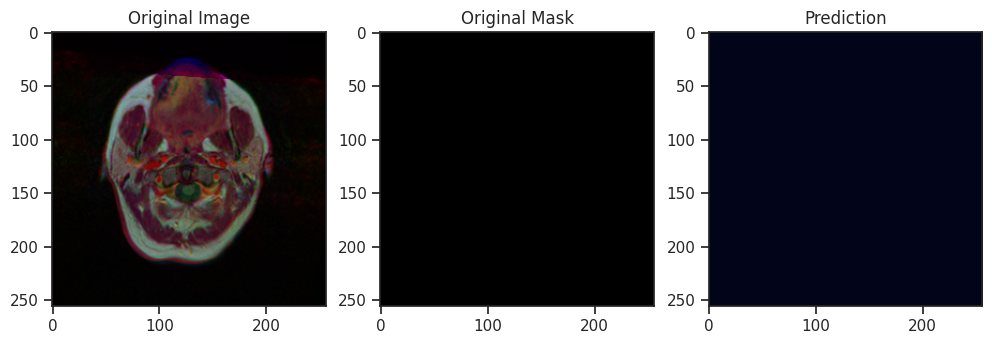

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


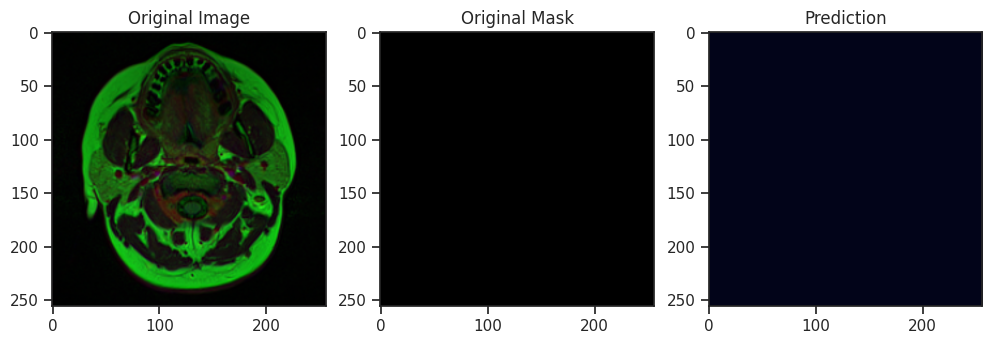

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


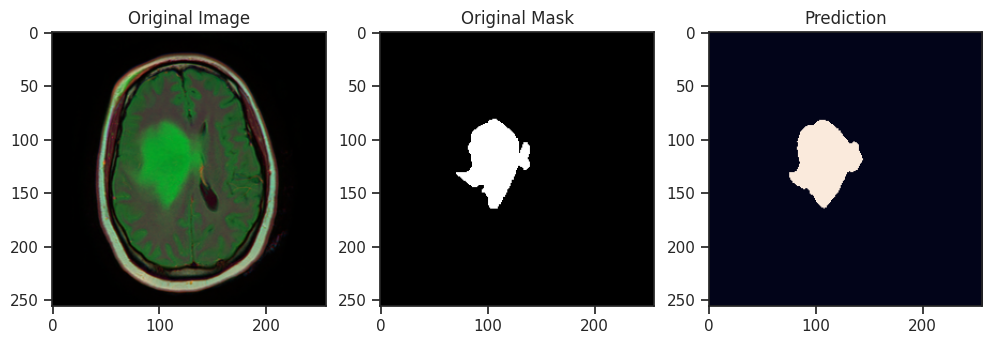

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


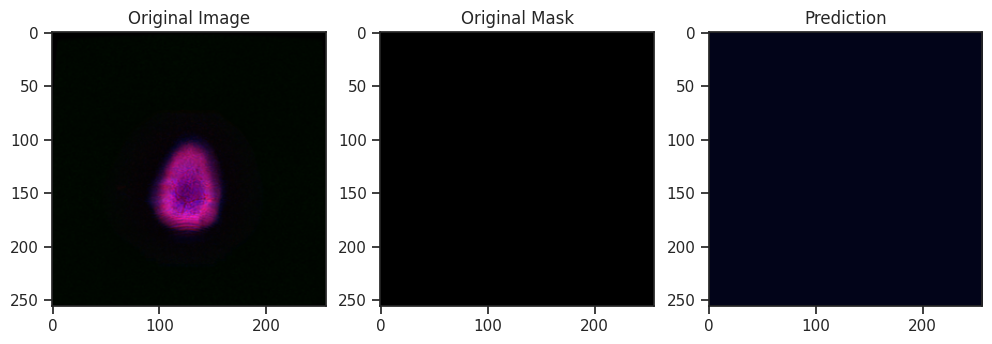

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()



**Image Loader**

In [ ]:
def load_single_image(image_path, img_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Shape: (1, H, W, 3)
    return img


**Testing Prediction**

In [ ]:
def predict_single_image(model, image_array):
    pred_mask = model.predict(image_array)[0]
    print("Prediction stats: min =", np.min(pred_mask),
          ", max =", np.max(pred_mask),
          ", mean =", np.mean(pred_mask))
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize
    return pred_mask



**Visualize input and output**

In [ ]:
def display_prediction(image_path, model, overlay=True):
    image_array = load_single_image(image_path)
    pred_mask = predict_single_image(model, image_array)

    plt.figure(figsize=(12, 4))

    # Input image
    plt.subplot(1, 3, 1)
    img_show = image_array[0, :, :, 0] if image_array.shape[-1] == 1 else image_array[0]
    plt.imshow(img_show, cmap='gray' if image_array.shape[-1] == 1 else None)
    plt.title("Input Image")
    plt.axis('off')

    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask[:, :, 0], cmap='Reds')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Overlay
    if overlay:
        plt.subplot(1, 3, 3)
        base_img = img_show if image_array.shape[-1] == 1 else image_array[0]
        plt.imshow(base_img, cmap='gray' if image_array.shape[-1] == 1 else None)
        plt.imshow(pred_mask[:, :, 0], cmap='jet', alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


**Loading Our Trained Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction stats: min = 3.7125657e-05 , max = 0.00031897178 , mean = 0.00014293299


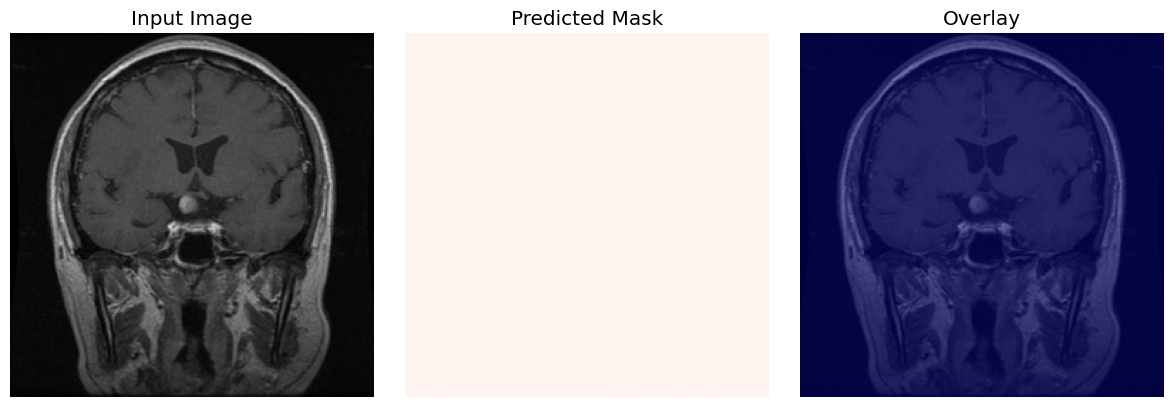

In [ ]:

model = load_model('unet.h5', compile=False)

test_image_path = '/content/drive/MyDrive/Colab Notebooks/Segmentation/brain_tumor_segmentation/images/1604.png'

display_prediction(test_image_path, model)
